# Install dependacies and import libraries

Firstly we will need to install a few things, namely pytorch! Each time you run the notebook you'll need to reinstall.

In [1]:
!apt-get install libsndfile1 -y && pip3 install librosa http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl torchvision pysoundfile

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libflac8 libogg0 libvorbis0a libvorbisenc2
The following NEW packages will be installed:
  libflac8 libogg0 libsndfile1 libvorbis0a libvorbisenc2
0 upgraded, 5 newly installed, 0 to remove and 4 not upgraded.
Need to get 555 kB of archives.
After this operation, 2,051 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/main amd64 libogg0 amd64 1.3.2-1 [17.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/main amd64 libflac8 amd64 1.3.2-1 [213 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/main amd64 libvorbis0a amd64 1.3.5-4 [85.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu artful/main amd64 libvorbisenc2 amd64 1.3.5-4 [70.8 kB]
Get:5 http://archive.ubuntu.com/ubuntu artful/main amd64 libsndfile1 amd64 1.0.28-4 [169 kB]
Fetched 555 kB in 0s (779 kB/s)
Selecting previously unselected package libogg0

    100% |████████████████████████████████| 592.3MB 20.3MB/s 
    100% |████████████████████████████████| 51kB 2.8MB/s 
    100% |████████████████████████████████| 184kB 4.5MB/s 
    100% |████████████████████████████████| 327kB 2.8MB/s 
    100% |████████████████████████████████| 5.9MB 226kB/s 
    100% |████████████████████████████████| 430kB 2.4MB/s 
    100% |████████████████████████████████| 1.9MB 705kB/s 
    100% |████████████████████████████████| 256kB 4.5MB/s 


    100% |████████████████████████████████| 14.8MB 80kB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /content/.cache/pip/wheels/7a/bf/9f/fc279e1814da2144161848a7419cdcf923d0c03f481abe7904
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /content/.cache/pip/wheels/47/cc/d8/e1476000d1720a72117ef5c0b1a51388b8567ebfface47ede7
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /content/.cache/pip/wheels/c6/8e/c0/4c402972789ddf6d2d701468417de19d0cad28bd698a867e2d
  Running setup.py bdist_wheel for pycparser ... - \ done
  Stored in directory: /content/.cache/pip/wheels/95/14/9a/5e7b9024459d2a6600aaa64e0ba485325aff7a9ac7489db1b6
Successfully built librosa audioread resampy pycparser
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
# Url management.
import io
from six.moves.urllib.request import urlopen

# For teacher forcing.
import random

# Audio libraries.
import IPython
import librosa
import librosa.display
import soundfile as sf

# A very useful numerical package.
import numpy as np

# NumPy on steriods.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

# Stats for outlier detection.
from scipy import stats
from sklearn import svm
from sklearn import decomposition
from sklearn.neighbors import LocalOutlierFactor

# To make nice plots.
import matplotlib.font_manager
import matplotlib.pyplot as plt

In [0]:
def to_var(x):
  if torch.cuda.is_available():
      x = x.cuda()
  return Variable(x)

# Build models

Now we build the generator and discriminator

In [0]:
class RNN(nn.Module):

  
  def __init__(self, input_size, hidden_size, number_layers, feature_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.number_layers = number_layers
    self.lstm = nn.LSTM(input_size=input_size, 
                        hidden_size=hidden_size, 
                        num_layers=number_layers, 
                        batch_first=True)
    self.linear = nn.Linear(hidden_size, feature_size)
    
    
  def forward(self, x):
    h0 = to_var(torch.zeros(self.number_layers, x.size(0), self.hidden_size)) 
    c0 = to_var(torch.zeros(self.number_layers, x.size(0), self.hidden_size))
    out, _ = self.lstm(x, (h0, c0))
    return self.linear(out[:, -1, :])
  
  
  
  
class EncoderRNN(nn.Module):
  
  """The encoder takes a batch of FFT frame sequences and returns encodings.
  
  There are no embeddings as the inputs are already real values, and the
  objective is to take FFT frames sequences (batch_size, sequence_length,
  fft_size) and return the encodings (batch_size, sequence_length, hidden_size).
  """
  
  def __init__(self, 
               input_size, 
               hidden_size, 
               number_layers=1, 
               dropout=0.1,
               bi_directional=True,
               rnn=nn.GRU):
    
    """The __init__ function.

    Sets up the encoder with the specified amount of layers and hidden size.
    Uses a different mask for each timestep, which has been shown to perform
    worse than if the mask was the same, for diffent layers at different
    timesteps as in https://arxiv.org/abs/1512.05287. So be wary of this! To
    entirely cancel out the dropout, just set dropout to zero.
    
    Arguments:
      input_size: Size of the input FFT frames.
      hidden_size: Size of the hidden learnable weights for the RNN.
      number_layers: How many layers the encoding RNN should have.
      dropout: Zero for no dropout, one for complete dropout.
      bi_directional: Whether or not the RNN should run in two directions.
      rnn_type: Pass a RNN module here such as nn.GRU or nn.LSTM.
    """
    
    super(EncoderRNN, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.number_layers = number_layers
    self.dropout = dropout
    self.bi_directional = bi_directional
    self.rnn = rnn(input_size=input_size,
                   hidden_size=hidden_size,
                   num_layers=number_layers, 
                   bidirectional=bi_directional)
    
    
  def forward(self, x, hidden):
    """The forward propoagation function. 
    
    The 
    """
    
    x, hidden = self.rnn(x, hidden)
    
    # linearly sum bi-directional outputs if appropriate.
    if self.bi_directional:
      forward = x[:, :, :self.hidden_size]
      backward = x[:, : ,self.hidden_size:]
      x = forward + backward
    
    return x, hidden

  
  
class Attention(nn.Module):
  
  """An attention module that can switch between different scoring methods.
  
  The general form of the attention calculation uses the target decoder hidden
  state and the encoder state.
  
  Find the scoring methods here: https://arxiv.org/abs/1508.04025. The options
  are; 'dot', a dot product between the decoder and encoder state; 'general', 
  the dot product between the decoder state and a linear transform of the
  encoder state; 'concat', a dot product between a new parameter 'v' and a 
  linear transform of the states concatenated together. Finally the result is
  normalised.
  """
  
  def __init__(self, method, hidden_size):
    super(Attention, self).__init__()
    
    self.method = method
    self.hidden_size = hidden_size
    
    if self.method == 'general':
      self.attention = nn.Linear(hidden_size, hidden_size)
      
    elif self.method == 'concat':
      self.attention = nn.Linear(hidden_size * 2, hidden_size)
      self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))
      
    
  def forward(self, hidden, encoder_outputs):
    max_length = encoder_outputs.size(0)
    batch_size = encoder_outputs.size(1)
    
    # Create variable to store attention energies.
    attention_energies = Variable(torch.zeros(batch_size, max_length))
    if torch.cuda.is_available():
      attention_energies = attention_energies.cuda()
      
    # For each encoder output, calculate the energies.
    for element in range(batch_size):
      for i in range(max_length):
        single_encoder_output = encoder_outputs[i, element].unsqueeze(0)
        attention_energies[element, i] = self.score(hidden[:, element], 
                                                    single_encoder_output)
        
    # Normalise the energies to weights in the range zero to one.
    normalised = F.softmax(attention_energies)
    return normalised.unsqueeze(1)
  
  
  def score(self, hidden, encoder_output):
    
    if self.method == 'dot':
      energy = hidden.dot(encoder_output)
      
    elif self.method == 'general':
      energy = self.attention(encoder_output)
      energy = hidden.dot(encoder_output)
      
    elif self.method == 'concat':
      concat = torch.cat((hidden, encoder_output), 1)
      energy = self.attention(concat)
      energy = self.v.dot(energy)
      
    return energy
      
        

class AttentionDecoderRNN(nn.Module):
  
  """Luong Attention Decoder RNN module.
  
  This decoder plugs in the Attention module ater the RNN to calculate the """
  
  def __init__(self, 
               attention_method, 
               hidden_size, 
               output_size, 
               number_layers=1, 
               dropout=0.1):
    
    super(AttentionDecoderRNN, self).__init__()
    
    self.attention_method = attention_method
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.number_layers = number_layers
    self.dropout = dropout
    self.rnn = nn.GRU(hidden_size, hidden_size, number_layers, dropout=dropout)
    self.concat = nn.Linear(hidden_size * 2, hidden_size)
    self.output = nn.Linear(hidden_size, output_size)
    self.attention = Attention(attention_method, hidden_size)
    
    
  def forward(self, input_sequence, last_hidden, encoder_outputs):
    batch_size = input_sequence.size(0)
    
    # Get current hidden state from input sequence and last hidden state.
    
    rnn_output, hidden = self.rnn(input_sequence, last_hidden)
    
    # Calculate attention from the current RNN state and all encoder outputs.
    attention_weights = self.attention(rnn_output, encoder_outputs)
    
    # bmm = batch matrix matrix product. Apply attention to encoder outputs to
    # get the weighted average.
    context = attention_weights.bmm(encoder_outputs.transpose(0, 1))
    
    
    # Attentional vector using the RNN hidden state and context vector
    # concatenated together (Luong eq. 5).
    rnn_output = rnn_output.squeeze(0)
    context = context.squeeze(1)
    concat_input = torch.cat((rnn_output, context), 1)
    concat_output = F.tanh(self.concat(concat_input))
    
    # Finally predict next frame (Luong eq. 6, without softmax).
    output = self.output(concat_output)
    
    # Return final output, hidden state, and attention weights. We can use the
    # attention weights for visualisation.
    return output, hidden, attention_weights
    
      
    
class DecoderRNN(nn.Module):
  
  

  def __init__(self, 
               input_size, 
               hidden_size, 
               number_layers=1, 
               dropout=0.1,
               bi_directional=True,
               rnn=nn.LSTM):
    
    """The __init__ function.

    Sets up the decoder with the specified amount of layers and hidden size.
    Uses a different mask for each timestep, which has been shown to perform
    worse than if the mask was the same, for different layers at different
    timesteps as in https://arxiv.org/abs/1512.05287. So be wary of this! To
    entirely cancel out the dropout, just set dropout to zero.
    
    Arguments:
      input_size: Size of the input FFT frames.
      hidden_size: Size of the hidden learnable weights for the RNN.
      number_layers: How many layers the decoding RNN should have.
      dropout: Zero for no dropout, one for complete dropout.
      bi_directional: Whether or not the RNN should run in two directions.
      rnn_type: Pass a RNN module here such as nn.GRU or nn.LSTM.
    """
    
    super(DecoderRNN, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.number_layers = number_layers
    self.dropout = dropout
    self.bi_directional = bi_directional
    self.rnn = rnn(input_size=input_size,
                   hidden_size=hidden_size,
                   num_layers=number_layers,
                   batch_first=False, 
                   bidirectional=bi_directional)

    
    def forward(self, x, hidden):
      """The forward propoagation function. 

      The 
      """

      x, hidden = self.rnn(x, hidden)

      # linearly sum bi-directional outputs if appropriate.
      if self.bi_directional:
        forward = x[:, :, :self.hidden_size]
        backward = x[:, : ,self.hidden_size:]
        x = forward + backward

      return x, hidden

# Test the encoder and decoder

In [0]:
if False:
  test_hidden_size     = 32
  test_input_size      = 32
  test_number_layers   = 3
  test_batch_size      = 16
  test_sequence_length = 7

  encoder_test = EncoderRNN(input_size=test_input_size,
                            hidden_size=test_hidden_size,
                            number_layers=test_number_layers)
  decoder_test = AttentionDecoderRNN('general',
                                     hidden_size=test_hidden_size,
                                     output_size=test_input_size,
                                     number_layers=test_number_layers)

  if torch.cuda.is_available():
    encoder_test.cuda()
    decoder_test.cuda()

  test_input_batches = to_var(torch.zeros(test_sequence_length,
                                          test_batch_size, 
                                          test_input_size))
  test_target_batches = to_var(torch.zeros(test_sequence_length,
                                           test_batch_size, 
                                           test_input_size))

  test_encoder_outputs, test_encoder_hidden = encoder_test(test_input_batches, None)

  # (batch_size, sequence_length, hidden_size)
  print('encoder outputs size      {}'.format(tuple(test_encoder_outputs.size())))

  # (number_layers * num_directions, sequence_length, hidden_size)
  print('encoder hidden state size {}'.format(tuple(test_encoder_hidden.size())))

  test_decoder_input = to_var(torch.zeros(1, test_batch_size, test_hidden_size))

  test_decoder_hidden = test_encoder_hidden[:decoder_test.number_layers]

  test_all_decoder_outputs = to_var(torch.zeros(test_sequence_length,
                                                test_batch_size, 
                                                test_input_size))  

  for time_step in range(test_sequence_length):
    test_decoder_output, test_decoder_hidden, test_decoder_attention = \
      decoder_test(test_decoder_input, test_decoder_hidden, test_encoder_outputs)

    # Store this step's outputs.
    test_all_decoder_outputs[time_step] = test_decoder_output 

    # Next input is current target.
    test_decoder_input = test_target_batches[time_step].view(1, 
                                                             test_batch_size,
                                                             test_input_size)
    test_decoder_input = test_decoder_output.view(1, 
                                                             test_batch_size,
                                                             test_input_size)

  test_criterion = nn.MSELoss()
  test_loss = test_criterion(test_all_decoder_outputs, test_target_batches)
  print(test_loss.data[0])

# Utilites

You can look for music urls [here](https://www.jewelbeat.com/free/free-background-music.htm)

In [0]:
class AudioDataset():
  """A class to convert audio found at an url to magnitude frames."""
  
  def __init__(self, url, fft_size, hop_length):
    self.fft_size = fft_size
    self.feature_size = (fft_size // 2) + 1
    self.hop_length = hop_length
    self.data, self.sample_rate = sf.read(io.BytesIO(urlopen(url).read()))
    self.data = np.mean(self.data, axis=1)
    self.stfts = librosa.stft(self.data, n_fft=fft_size, hop_length=hop_length)
    self.magnitudes, _ = librosa.magphase(self.stfts.T)
  
  
  def get_next_batch(self, amount_epochs, batch_size, sequence_length):
    
    self.dataset_size = len(self.magnitudes) - sequence_length * 2 - 1
    
    self.x = np.zeros((self.dataset_size, sequence_length, self.feature_size), 
                       dtype=np.float32)
    self.y = np.zeros((self.dataset_size, sequence_length, self.feature_size), 
                       dtype=np.float32)
    
    for i, x_start in enumerate(range(0, self.dataset_size)):
      y_start = x_end = x_start + sequence_length
      y_end = y_start + sequence_length

      self.x[i] = self.magnitudes[x_start:x_end]
      self.y[i] = self.magnitudes[y_start:y_end]
    
    for epoch in range(amount_epochs):
      
      permuation = np.random.permutation(len(self.x))
      x, y = self.x[permuation], self.y[permuation]

      for start in range(0, len(x) - batch_size, batch_size):
        end = start + batch_size

        batch_x = torch.from_numpy(x[start:end])
        batch_y = torch.from_numpy(y[start:end])

        yield to_var(batch_x), to_var(batch_y), epoch 
        
        
        
def griffin_lim(spectrogram, n_iter=100, window='hann', n_fft=2048, hop_length=-1):
  if hop_length == -1:
    hop_length = n_fft // 4

  angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))

  for i in range(n_iter):
    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length = hop_length, window = window)
    rebuilt = librosa.stft(inverse, n_fft = n_fft, hop_length = hop_length, window = window)
    angles = np.exp(1j * np.angle(rebuilt))

  full = np.abs(spectrogram).astype(np.complex) * angles
  inverse = librosa.istft(full, hop_length = hop_length, window = window)

  return inverse
    
  
  
def outlier_detection(data, 
                      contamination_fraction=0.25, 
                      amount_neighbours=35, 
                      figure_width=8,
                      append_covariance=False,
                      inline=False):
  
  # Get rank-2 data points.
  number_data_points = len(data)
  data = np.array(data).reshape((number_data_points, -1))

  # perform dimensionality reduction if necessary for visualisation.
  if data.shape[1] > 2:
    pca = decomposition.PCA(n_components=2)
    pca.fit(data)
    data = pca.transform(data)
    
  # Setup.
  xx, yy = np.meshgrid(np.linspace(data.min(), data.max(), 100), 
                       np.linspace(data.min(), data.max(), 100))
    
  # Instanciate outlier detection methods and find anomolies & descision bounds.
  lof = LocalOutlierFactor(n_neighbors=amount_neighbours,
                           contamination=contamination_fraction)
  lof_predictions = lof.fit_predict(data)
  lof_scores_pred = lof.negative_outlier_factor_
  lof_threshold = stats.scoreatpercentile(lof_scores_pred, 
                                          100 * contamination_fraction)
  lof_z = lof._decision_function(np.c_[xx.ravel(), yy.ravel()])
  
  # Plot everything.
  plot_data = [
      ('Local Outlier Factor', lof_z, lof_threshold, lof_predictions)
  ]
  
  # Add robust covarince method. Need fix decision boundary!
  if append_covariance:
    env = EllipticEnvelope(contamination=contamination_fraction)
    env.fit(data)
    env_predictions = env.decision_function(data)
    env_scores_pred = env.predict(data)
    env_threshold = stats.scoreatpercentile(env_scores_pred,
                                            100 * contamination_fraction)
    env_z = env.decision_function(np.c_[xx.ravel(), yy.ravel()])
    cova_data = ('Robust Covariance', env_z, env_threshold, env_scores_pred)
    plot_data.append(cova_data)
    
  fig = plt.figure(figsize=(figure_width, figure_width * len(plot_data)))
  plot_number = 1
  for title, z, threshold, predictions in plot_data:
    z = z.reshape(xx.shape)
    sub_plot = fig.add_subplot(len(plot_data), 1, plot_number)
    sub_plot.contourf(xx, yy, z, levels=np.linspace(z.min(), threshold, 7), cmap=plt.cm.Blues_r)
    sub_plot.contour(xx, yy, z, levels=[threshold], linewidths=2, colors='red')
    sub_plot.contourf(xx, yy, z, levels=[threshold, z.max()], colors='orange')

    inliers = data[np.where(predictions == 1)]
    outliers = data[np.where(predictions == -1)]
    sub_plot.scatter(inliers[:,0], inliers[:,1], c='white', s=20, edgecolor='k')
    sub_plot.scatter(outliers[:,0], outliers[:,1], c='black', s=20, edgecolor='k')

    sub_plot.axis('tight')
    sub_plot.set_xlabel(title)
    sub_plot.set_xlim((data.min(), data.max()))
    sub_plot.set_ylim((data.min(), data.max()))
    
    plot_number += 1
  
  # Convert to NumPy array and return!
  fig.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
  fig.suptitle("Outlier detection")
  
  if not inline:
    plt.close()
  else:
    fig.savefig('outlier_detection.png', dpi=fig.dpi)
  
  return fig, np.where(lof_predictions == -1)[0]



def plot_audio(data):
  stft = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
  librosa.display.specshow(stft, y_axis='log')
  

# Train and inference functions

In [0]:
def train(encoder, 
          decoder, 
          encoder_optimiser,
          decoder_optimiser, 
          input_batch, 
          target_batch,
          criterion,
          clip_threshold,
          use_teacher_forcing):
  
  # Zero the gradients of both optimisers.
  encoder_optimiser.zero_grad()
  decoder_optimiser.zero_grad()
  
  sequence_length, batch_size, fft_size = tuple(input_batch.size())
  
  # Run the input batch of fft sequences through the encoder.
  encoder_outputs, encoder_hidden = encoder(input_batch, None)
  
  # Prepare the input and output variables.
  # THINK. Should the start of sentance (~SOS_token) begin with a zero'd vector?
  decoder_input = to_var(torch.zeros(1, batch_size, fft_size))
  decoder_hidden = encoder_hidden[:decoder.number_layers]
  all_decoder_outputs = to_var(torch.zeros(sequence_length,
                                           batch_size,
                                           fft_size)) 
  
  # Iterate over the decoder one step at a time.
  for time_step in range(sequence_length):
    
    # Get the output, state and attention.
    decoder_output, decoder_hidden, decoder_attention = \
      decoder(decoder_input, decoder_hidden, encoder_outputs)
    
    # Store the output.
    all_decoder_outputs[time_step] = decoder_output
    
    # Prepare the next input depending on teacher forcing.
    if use_teacher_forcing:
      decoder_input = target_batch[time_step].view(1, batch_size, fft_size)      
    else:
      decoder_input = decoder_output.view(1, batch_size, fft_size)
   
  # How close were we to the targets?
  loss = criterion(all_decoder_outputs, target_batch)
  loss.backward()
  
  # Clip the gradient norms.
  torch.nn.utils.clip_grad_norm(encoder.parameters(), clip_threshold)
  torch.nn.utils.clip_grad_norm(decoder.parameters(), clip_threshold)
  
  # Update parameters with optimisers.
  encoder_optimiser.step()
  decoder_optimiser.step()
  
  return loss.data[0]   

In [0]:
def run(rnn, dataset, sequence_length, amount_frames):
  
  # Get random sequence from dataset object. 
  index = np.random.randint(low=0, high=dataset.dataset_size)
  frames = to_var(torch.from_numpy(dataset.x[index]))
  
  # Repeatedly sample the RNN and get the output.
  for i in range(amount_frames):
    model_input = frames[i:i + sequence_length].view(1, sequence_length, -1)
    
    
    # Are we correctly getting the most recent chunk of frames to input to the
    # RNN?
    assert (i + sequence_length) == len(frames)
    
    new_frame = rnn(model_input)
    frames = torch.cat((frames, new_frame))
    
  frames = frames.cpu()
  return frames.data.numpy()
  

# Hyper parameters

Settings Done.
Encoder Done.
Decoder Done.


/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


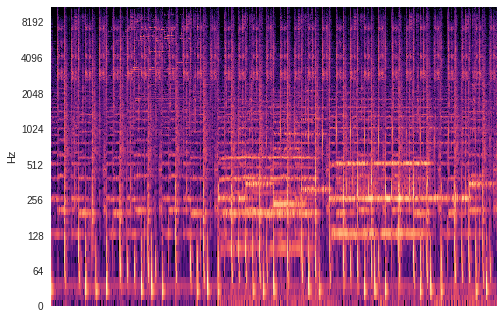

In [21]:
# Hyper parameters.
seed                   = 42
attention_method       = 'general'
fft_size               = 512
number_layers          = 2
dropout                = 0.0
sequence_length        = 30
teacher_force_ratio    = 0.5
clip_threshold         = 5.0
criterion              = nn.MSELoss()
learning_rate          = 0.0001
decoder_learning_ratio = 5.0
batch_size             = 128
number_epochs          = 100
evaluate_every         = 10
feature_size = input_size = hidden_size = (fft_size // 2) + 1
hop_length = fft_size // 4

url = 'http://www.jewelbeat.com/free/free-music/JewelBeat%20-%20Haunted%20Revenge.wav'

print("Settings Done.")

# Construct RNNs and optimisers.
encoder = EncoderRNN(input_size=feature_size,
                     hidden_size=feature_size,
                     number_layers=number_layers,
                     dropout=dropout)

print("Encoder Done.")

decoder = AttentionDecoderRNN(attention_method,
                              hidden_size=hidden_size,
                              output_size=feature_size,
                              number_layers=number_layers,
                              dropout=dropout)

print("Decoder Done.")

# Enable GPU tensors provided GPUs actually exist!
if torch.cuda.is_available():
  encoder.cuda()
  decoder.cuda()
  criterion.cuda()
  torch.cuda.manual_seed(seed)
else:
  torch.manual_seed(seed)
  
encoder_optimiser = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimiser = torch.optim.Adam(decoder.parameters(), 
                                     lr=learning_rate * decoder_learning_ratio)


dataset = AudioDataset(url, fft_size, hop_length)

# Plot and listen to the audio.
plot_audio(dataset.data) 
IPython.display.Audio(dataset.data, rate=dataset.sample_rate)

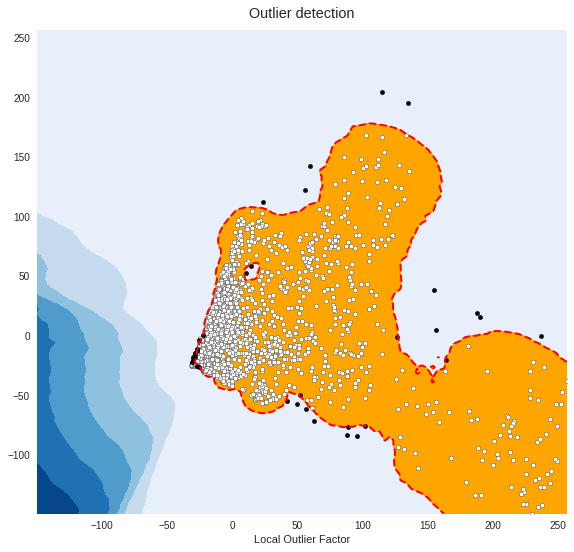

In [18]:
_ = outlier_detection(dataset.magnitudes, contamination_fraction=0.01, inline=True)

In [0]:
get_batch = dataset.get_next_batch(number_epochs, batch_size, sequence_length)
for x, y, epoch in get_batch:

  if random.random() < teacher_force_ratio:
    use_teacher_forcing = True  
  else: 
    use_teacher_forcing = False

  loss = train(encoder, 
               decoder, 
               encoder_optimiser,
               decoder_optimiser,
               x, 
               y,
               criterion, 
               clip_threshold, 
               use_teacher_forcing)
  print(loss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:135: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


8.119806289672852
7.390567302703857
8.655777931213379
6.321857929229736
5.984663963317871
8.619384765625
6.337202072143555
7.04356050491333
6.690426349639893
6.060835361480713
8.815169334411621
7.051423072814941
6.198267936706543
7.096005439758301
6.184321880340576
5.478331565856934
5.239377021789551
4.419581413269043
5.929306507110596
6.797762870788574
6.41439151763916
6.52555513381958
6.423908710479736
5.372025966644287
5.299868106842041
6.251220226287842
6.434965133666992
5.09740686416626
5.609441757202148
6.144229412078857
5.01567268371582
6.302165985107422
5.726134777069092
4.836015224456787
5.23545503616333
4.838354110717773
4.52401876449585
5.342427730560303
5.319845199584961
5.271417617797852
5.967138290405273
4.9555816650390625
6.161592960357666
5.3656535148620605
5.606243133544922
4.478532791137695
5.689917087554932
6.081916332244873
5.082866191864014
5.22468900680542
5.568726539611816
5.123417854309082
5.744430065155029
4.491105079650879
5.905007362365723
5.268115997314453
5

5.465181350708008
5.317593097686768
6.1744794845581055
6.202507019042969
5.363974571228027
5.568747043609619
5.615609169006348
6.111110210418701
4.723763465881348
5.6132988929748535
5.708847999572754
5.546890735626221
4.825749397277832
5.687841892242432
3.9673190116882324
5.237700462341309
4.974242687225342
5.721070289611816
4.635611057281494
4.617977142333984
5.4747514724731445
6.153118133544922
5.912806034088135
4.9294328689575195
5.893192291259766
5.1081223487854
5.186852931976318
5.775905609130859
4.777858734130859
5.760926723480225
5.557889461517334
4.857697010040283
5.633906364440918
5.8750691413879395
5.115549564361572
5.317646503448486
5.267063140869141
5.332849502563477
5.439079761505127
6.063003063201904
5.327787399291992
5.1164445877075195
5.966546058654785
4.945449352264404
4.647939682006836
5.708636283874512
5.362084865570068
5.613853454589844
5.256189346313477
5.892701148986816
6.136589527130127
4.05416202545166
5.518421649932861
5.955316066741943
6.327382564544678
5.8945

/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


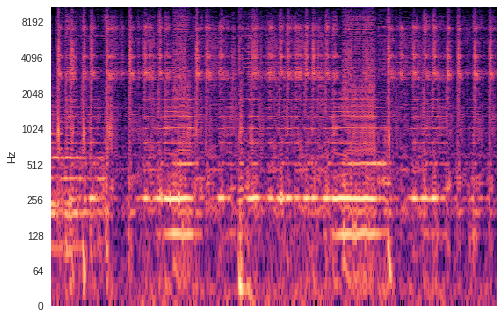

In [0]:
magnitudes = run(rnn, dataset, sequence_length, 1000)
predicted_audio = griffin_lim(magnitudes.T, 
                              n_iter=100, 
                              window='hann', 
                              n_fft=fft_size, 
                              hop_length=hop_length)

plot_audio(predicted_audio) 
IPython.display.Audio(predicted_audio, rate=dataset.sample_rate)